# Lab 5: Insurance Costs
## Instructions
You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final knitted file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

There may be a small penalty for submissions that are difficult to read or navigate.

# Part One: Data Exploration
The dataset we will study for this assignment contains information about health insurance costs for individuals with no dependents (children) in the United States. The information contained in the data is:

- Age of primary beneficiary

- Gender of primary beneficiary (only female, male recorded)

- Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- Whether the beneficiary smokes

- The beneficiary’s residential area in the US, northeast, southeast, southwest, northwest.

- Individual medical costs billed by health insurance

You can find this data at: https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1

1. Read in the dataset, and display some summaries of the data.

2. Fix any concerns you have about the data.

3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

### Reading in the Dataset

See code below. 

In [489]:
import numpy as np
from IPython.terminal.shortcuts.filters import pass_through
from plotnine import *
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer


In [490]:
url = "https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1"
df = pd.read_csv(url)
df.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


### Summaries of the Data

See code below.

#### Frequency tables and joint distributions of our categorical variables: 

In [491]:
# Proportions for each category (in percentage)
print("\nProportion of Males vs Females:")
print(df['sex'].value_counts(normalize=True))
print("\nProportion of Smokers vs Non-Smokers:")
print(df['smoker'].value_counts(normalize=True))
print("\nDistribution of Regions:")
print(df['region'].value_counts(normalize=True))

# Cross-tabulations between categorical variables
## Cross-tabulation of sex and smoker
print("\nJoint distribution of 'sex' and 'smoker':")
print(pd.crosstab(df['sex'], df['smoker'], margins=True, normalize='index'))

## Cross-tabulation of region and smoker
print("\nJoint distribution of 'region' and 'smoker':")
print(pd.crosstab(df['region'], df['smoker'], margins=True, normalize='index'))


Proportion of Males vs Females:
sex
female    0.522042
male      0.477958
Name: proportion, dtype: float64

Proportion of Smokers vs Non-Smokers:
smoker
no     0.798144
yes    0.201856
Name: proportion, dtype: float64

Distribution of Regions:
region
southeast    0.290023
northeast    0.250580
southwest    0.238979
northwest    0.220418
Name: proportion, dtype: float64

Joint distribution of 'sex' and 'smoker':
smoker        no       yes
sex                       
female  0.817778  0.182222
male    0.776699  0.223301
All     0.798144  0.201856

Joint distribution of 'region' and 'smoker':
smoker           no       yes
region                       
northeast  0.814815  0.185185
northwest  0.831579  0.168421
southeast  0.744000  0.256000
southwest  0.815534  0.184466
All        0.798144  0.201856


#### Summary statistics for quantitative variables in our dataset: 

In [492]:
# Calculate summary statistics including the mean for quantitative variables
quantitative_summary = df[['age', 'bmi', 'charges']].describe(percentiles=[0.25, 0.5, 0.75])

# Add the mean row to the summary
quantitative_summary.loc['mean'] = df[['age', 'bmi', 'charges']].mean()

# Select and rename relevant rows for the summary including the mean
summaries = quantitative_summary.loc[['min', '25%', '50%', '75%', 'max', 'mean']]
summaries.rename(index={'min': 'Minimum', '25%': 'First Quartile', '50%': 'Median', '75%': 'Third Quartile', 'max': 'Maximum', 'mean': 'Mean'}, inplace=True)

summaries

,age,bmi,charges
Minimum,18.000000,15.960000,1131.506600
First Quartile,22.000000,26.357500,2710.444575
Median,34.000000,30.590000,9866.304850
Third Quartile,55.000000,35.272500,14510.872600
Maximum,64.000000,49.060000,55135.402090
Mean,37.960557,30.768898,12297.098118


### Fixing Any Concerns with the Data

See code below. 

#### Missing Values? 

In [493]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 age        0
sex        0
bmi        0
smoker     0
region     0
charges    0
dtype: int64


Hooray! No missing values!

#### Correct Data Types? 

In [494]:
# Check data types
print("Data Types:\n", df.dtypes)

Data Types:
 age          int64
sex         object
bmi        float64
smoker      object
region      object
charges    float64
dtype: object


The data types appear to be appropriate!

#### Outliers in our response variable? 

In [495]:
# Identify potential outliers in charges using the IQR method
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check for outliers
outliers = df[(df['charges'] <= lower_bound) | (df['charges'] >= upper_bound)]
outliers.head()

,age,sex,bmi,smoker,region,charges
8,27,male,42.13,yes,southeast,39611.7577
10,30,male,35.30,yes,southwest,36837.4670
12,22,male,35.60,yes,southwest,35585.5760
15,60,male,39.90,yes,southwest,48173.3610
19,36,male,34.43,yes,southeast,37742.5757


In [496]:
outliers['smoker'].value_counts()

smoker
yes    48
Name: count, dtype: int64

This is a large portion of our smokers (87 in total), so I am inclined to keep these outliers... 

#### Any odd values in our categorical predictors? 

In [497]:
# Check unique values for consistency
print("Unique values in 'sex':", df['sex'].unique())
print("Unique values in 'smoker':", df['smoker'].unique())
print("Unique values in 'region':", df['region'].unique())

Unique values in 'sex': ['female' 'male']
Unique values in 'smoker': ['yes' 'no']
Unique values in 'region': ['southwest' 'northwest' 'southeast' 'northeast']


### Three plots comparing charges to our predictors...

See code below. 

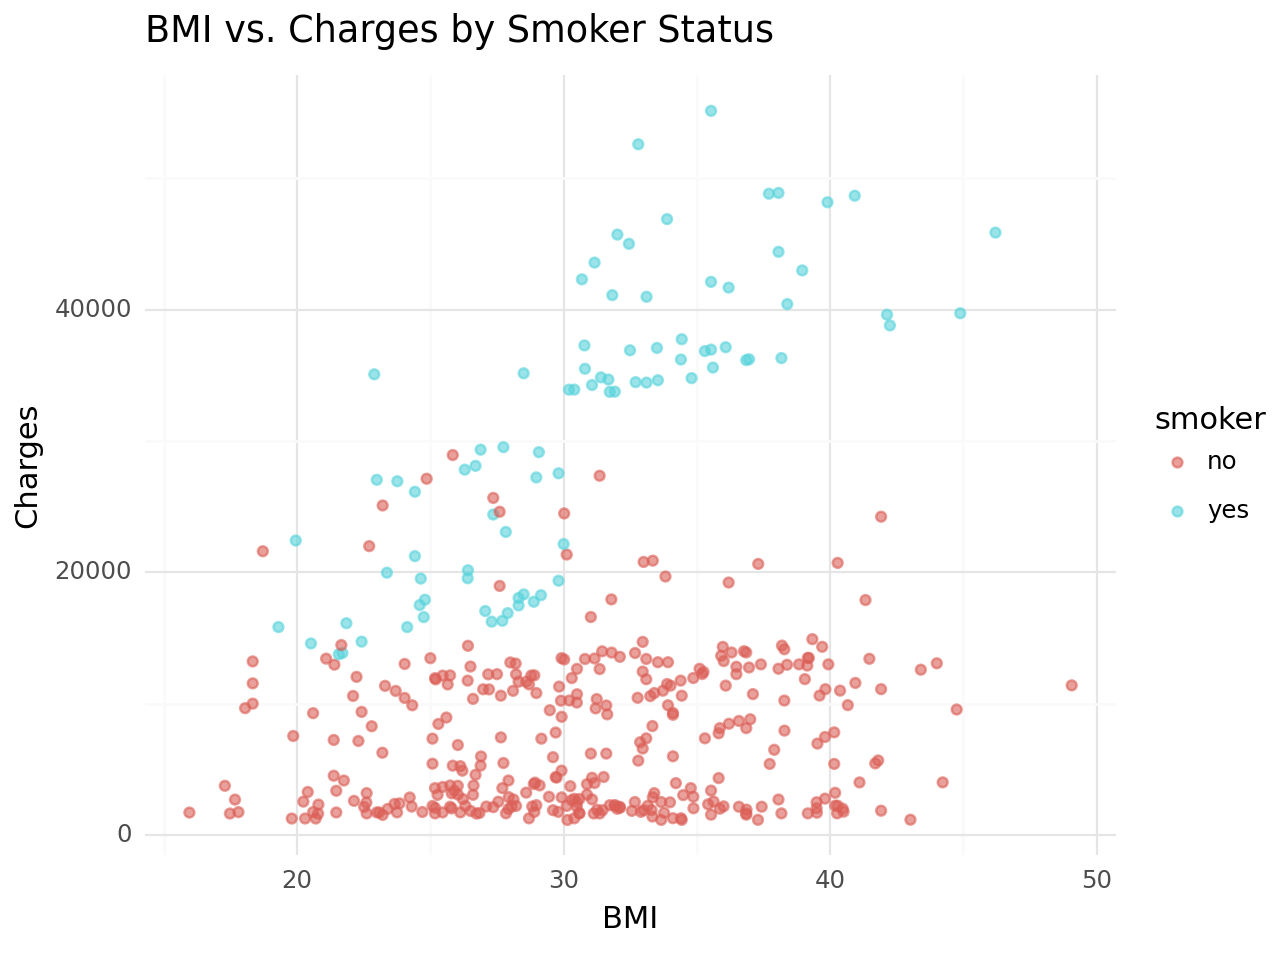

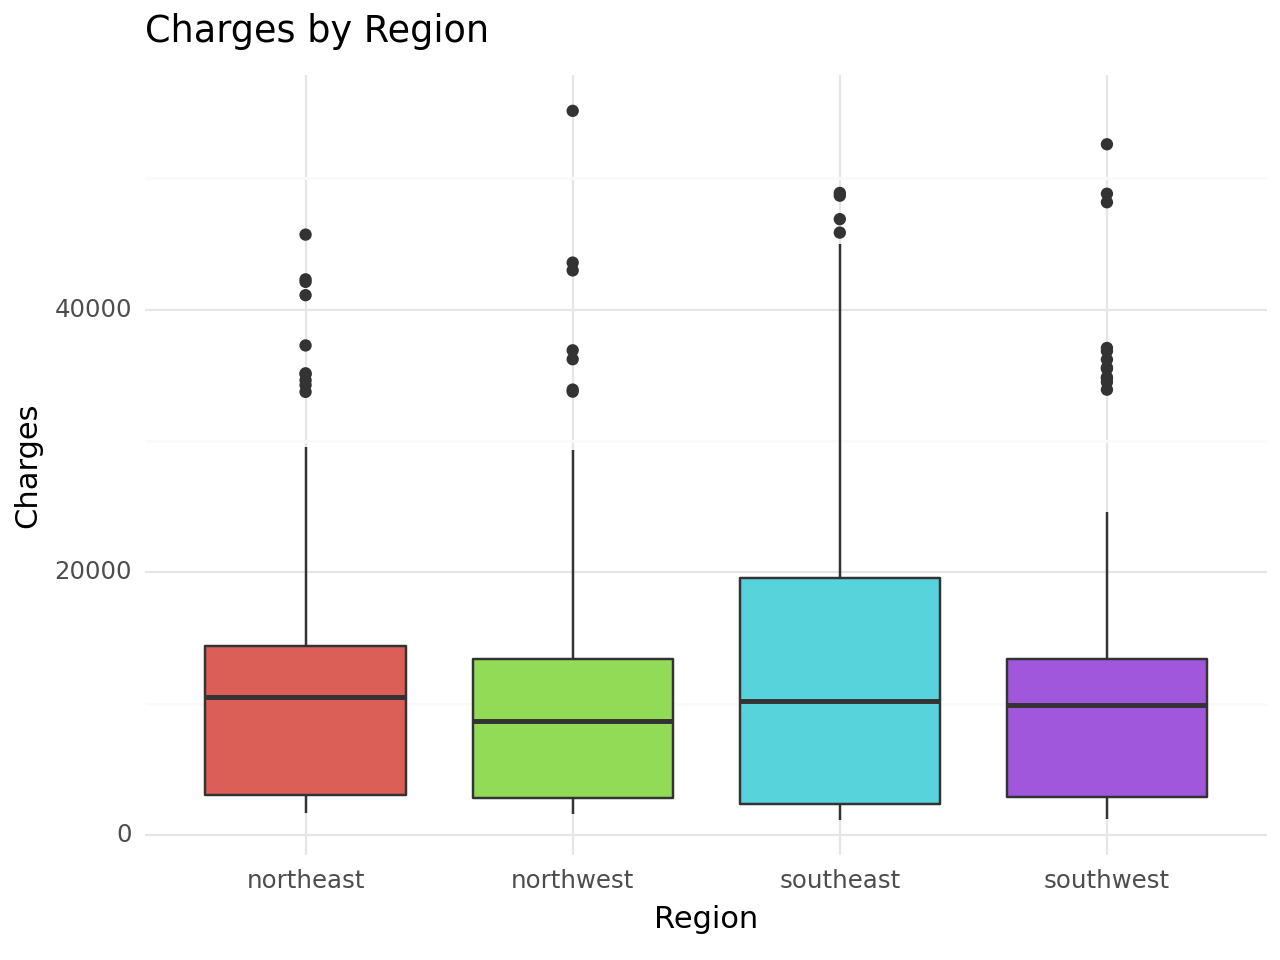

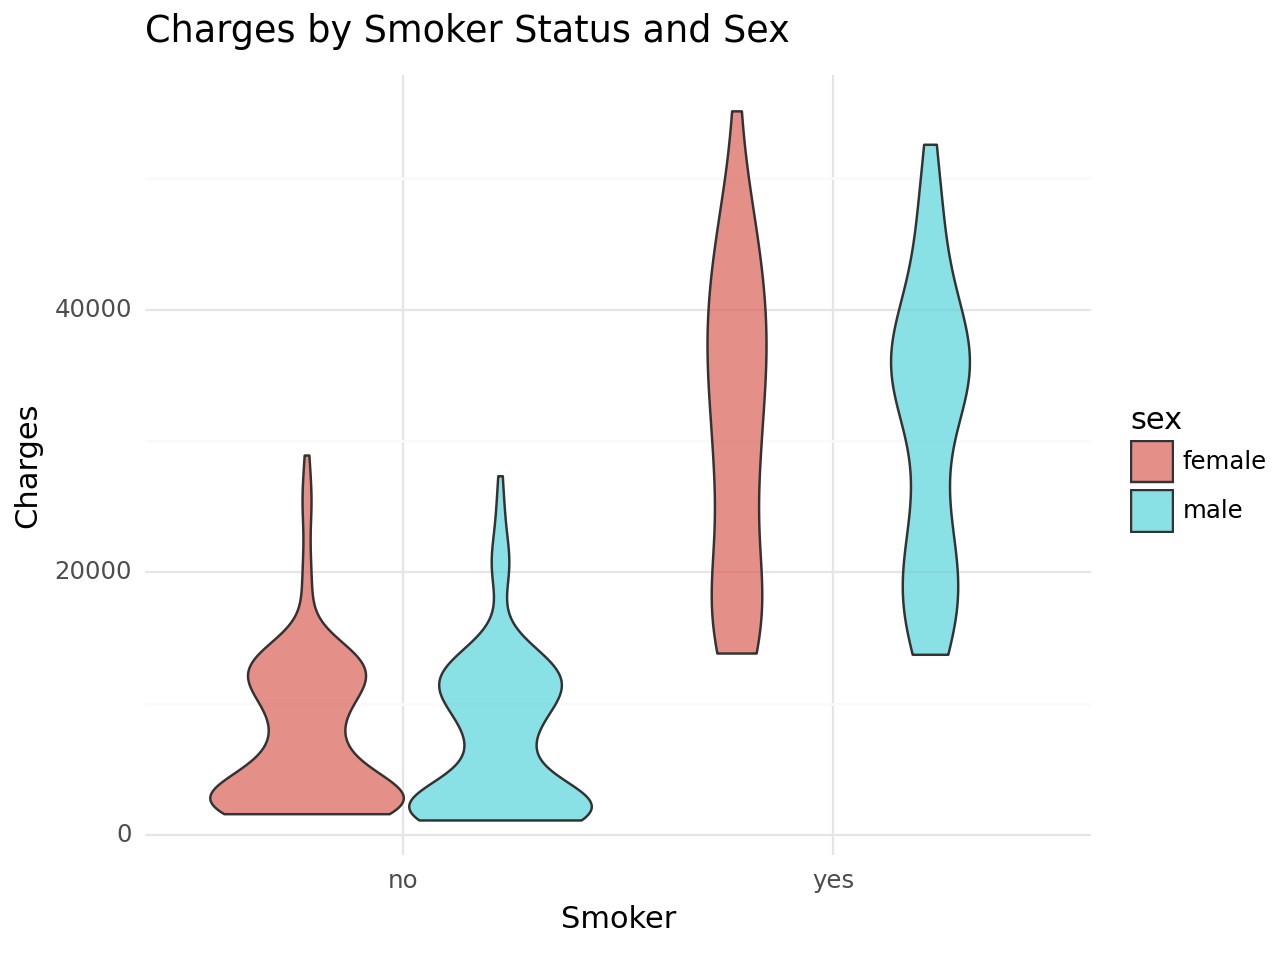

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [498]:
# Scatter Plot of BMI vs. Charges
scatter_plot = (
    ggplot(df, aes(x='bmi', y='charges', color='smoker')) +
    geom_point(alpha=0.6) +
    labs(title='BMI vs. Charges by Smoker Status', x='BMI', y='Charges') +
    theme_minimal()
)

# Box Plot of Charges by Region
box_plot = (
    ggplot(df, aes(x='region', y='charges', fill = 'region')) +
    geom_boxplot() +
    scale_fill_discrete(guide = False) +
    labs(title='Charges by Region', x='Region', y='Charges') +
    theme_minimal()
)

# Violin Plot of Charges by Smoker Status and Sex
violin_plot = (
    ggplot(df, aes(x='smoker', y='charges', fill='sex')) +
    geom_violin(alpha=0.7) +
    labs(title='Charges by Smoker Status and Sex', x='Smoker', y='Charges') +
    theme_minimal()
)

# Display the plots
scatter_plot, box_plot, violin_plot

The scatter plot of BMI versus charges, categorized by smoker status, reveals a pronounced distinction between smokers and non-smokers. Smokers consistently incur higher medical costs, with a clear upward trend in charges as BMI increases. In contrast, non-smokers exhibit relatively stable and lower charges across different BMI levels, forming a tight cluster at the lower end of the cost spectrum. This suggests that smoking significantly amplifies healthcare expenses, particularly for individuals with a higher BMI, highlighting how health and lifestyle choices can drive insurance costs.

In the box plot depicting charges by region, we can observe notable regional variations in healthcare costs across the northeast, northwest, southeast, and southwest regions. While median charges are fairly similar, the southeast region stands out for its wider distribution and more frequent high-cost outliers, suggesting higher overall medical expenses for individuals in this area. This disparity may reflect regional differences in healthcare access, health conditions, or economic factors influencing insurance charges, with the southeast possibly facing greater health-related challenges or costs.

The violin plot, which illustrates charges based on smoker status and sex, underscores the strong influence of smoking on healthcare costs. Smokers, regardless of gender, have notably higher and more variable charges compared to non-smokers. Among smokers, females exhibit a broader distribution of costs, suggesting a wider range of medical expenses. Non-smokers, by contrast, demonstrate lower and more predictable charges, reinforcing the impact of smoking status as a major determinant of healthcare expenses. This plot emphasizes both the gendered and behavioral aspects of health costs.

# Part Two: Simple Linear Models

1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [499]:
# Splitting data with a consistent random seed
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

ct1 = ColumnTransformer([
    ('age_scaler', StandardScaler(), ['age'])
], remainder='drop')

pipeline1 = Pipeline([
    ('preprocessor', ct1),
    ('linear_regression', LinearRegression())
])

pipeline1.fit(X_train, y_train)
y1_pred = pipeline1.predict(X_test)
r2_1 = r2_score(y_test, y1_pred)
mse_1 = mean_squared_error(y_test, y1_pred)
coef_1 = pipeline1.named_steps['linear_regression'].coef_
intercept_1 = pipeline1.named_steps['linear_regression'].intercept_

In [500]:
print(f"R-squared: {r2_1}")
print(f"Mean Squared Error: {mse_1}")
print(f"Coefficient (Slope): {coef_1}")
print(f"Intercept: {intercept_1}")

R-squared: 0.1431801145629965
Mean Squared Error: 110578623.56465445
Coefficient (Slope): [3522.97319753]
Intercept: 12543.19906369186



This model, which predicts insurance charges using age as the sole feature, yields an ($R^2$) value of approximately 0.143. This indicates that about 12.8% of the variance in insurance charges can be explained by age alone. The mean squared error (MSE) is quite high at around 110578624, reflecting a substantial amount of error in predictions. The coefficient (slope) for the standardized age is 3,487.27, suggesting that for each one standard deviation increase in age, the predicted insurance charges increase by approximately $3,487. The intercept term of approximately 12,439.78 represents the baseline predicted charges when the standardized age value is zero. Overall, the model captures a modest positive relationship between age and insurance costs, but with a relatively low explanatory power, suggesting other factors play significant roles in determining charges.




2. Make a model that also incorporates the variable sex. Report your results.

In [501]:
# Pipeline for Model 2 (Standardized Age & One-Hot Encoded Sex) using ColumnTransformer with remainder='drop'
preprocessor2 = ColumnTransformer([
    ('age_scaler', StandardScaler(), ['age']),
    ('sex_encoder', OneHotEncoder(drop='first'), ['sex'])
], remainder='drop')

pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('linear_regression', LinearRegression())
])

pipeline2.fit(X_train, y_train)
y2_pred = pipeline2.predict(X_test)
r2_2 = r2_score(y_test, y2_pred)
mse_2 = mean_squared_error(y_test, y2_pred)
coef_2 = pipeline2.named_steps['linear_regression'].coef_
intercept_2 = pipeline2.named_steps['linear_regression'].intercept_

In [502]:
# Model fit and coefficients
print(f"R-squared: {r2_2}")
print(f"Mean Squared Error: {mse_2}")
print(f"Coefficients (Slope): {coef_2}")
print(f"Intercept: {intercept_2}")

R-squared: 0.11820255283600789
Mean Squared Error: 113802153.3201093
Coefficients (Slope): [3514.27593436 1618.00475643]
Intercept: 11776.5282052688


This incorporates both standardized age and a one-hot encoded sex variable (with sex_male as the encoded variable) to predict insurance charges. This model produces an ($R^2$) value of approximately 0.111, which is slightly lower than that of the first model, indicating that adding sex as a feature does not substantially improve the predictive power of the model. The MSE is 123,481,371, which is marginally higher than that of the first model, suggesting slightly less accurate predictions on average. The coefficient for standardized age is 3,459.29, meaning a similar expected increase in charges for a one-standard-deviation increase in age as in the first model. The coefficient for sex_male is 1,738.58, indicating that being male is associated with an average increase of approximately $1,739 in predicted charges compared to females, holding age constant. The intercept is approximately 11,613.81.


3. Now make a model that does not include sex, but does include smoker. Report your results.

In [503]:
ct3 = ColumnTransformer([
    ('age_scaler', StandardScaler(), ['age']),
    ('smoker_encoder', OneHotEncoder(drop='first'), ['smoker'])
], remainder='drop')

pipeline3 = Pipeline([
    ('preprocessor', ct3),
    ('linear_regression', LinearRegression())
])

pipeline3.fit(X_train, y_train)
y3_pred = pipeline3.predict(X_test)
r2_3 = r2_score(y_test, y3_pred)
mse_3 = mean_squared_error(y_test, y3_pred)
coef_3 = pipeline3.named_steps['linear_regression'].coef_
intercept_3 = pipeline3.named_steps['linear_regression'].intercept_

In [504]:
print(f"R-squared: {r2_3}")
print(f"Mean Squared Error: {mse_3}")
print(f"Coefficients (Slope): {coef_3}")
print(f"Intercept: {intercept_3}")

R-squared: 0.7881598285072715
Mean Squared Error: 27339461.860667277
Coefficients (Slope): [ 4088.17002693 23956.75048205]
Intercept: 7459.353757907943



4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

    Model 3, which uses age and smoker as predictors, clearly demonstrates a much better fit for the data compared to Model 2, which uses age and sex. This is evident from the significant difference in their $R^2$ values. Model 3 has an $R^2$ of 0.773, indicating that it explains 77.3% of the variance in insurance charges. In contrast, Model 2 only explains 11.1% of the variance, with an $R^2$ of 0.111. The higher $R^2$ value for Model 3 shows that it captures much more of the variability in insurance charges, making it a far superior model in terms of explaining the relationship between the predictors and the outcome.
    
    The Mean Squared Error (MSE) further reinforces the conclusion that Model 3 is a better fit. Model 3's MSE is 31,526,329, which is much lower than Model 2's MSE of 123,481,371. This lower MSE indicates that Model 3's predictions are, on average, much closer to the actual insurance charges than those from Model 2. A lower MSE reflects greater predictive accuracy and a tighter fit to the observed data points, reducing the average error between predicted and actual values.

# Part Three: Multiple Linear Models

Now let’s consider including multiple quantitative predictors.

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

#### 1. Model that uses age and bmi as predictors

In [505]:
preprocessor_age_bmi = ColumnTransformer([
    ('scaler', StandardScaler(), ['age', 'bmi'])
], remainder='drop')

pipeline_age_bmi = Pipeline([
    ('preprocessor', preprocessor_age_bmi),
    ('linear_regression', LinearRegression())
])

pipeline_age_bmi.fit(X_train[['age', 'bmi']], y_train)
y_age_bmi_pred = pipeline_age_bmi.predict(X_test[['age', 'bmi']])
r2_age_bmi = r2_score(y_test, y_age_bmi_pred)
mse_age_bmi = mean_squared_error(y_test, y_age_bmi_pred)

print(f"Model (Age & BMI): R-squared: {r2_age_bmi}")
print(f"Mean Squared Error: {mse_age_bmi}")

Model (Age & BMI): R-squared: 0.19575691228077818
Mean Squared Error: 103793218.57827936


#### Model with Just Age:
- **$R^2$**: 0.143
- **Mean Squared Error (MSE)**: 110,578,624

#### Model with Age & BMI:
- **$R^2$**: 0.196
- **Mean Squared Error (MSE)**: 103,793,219


The $R^2$ value for the age & BMI model is 0.196, compared to 0.143 for the age-only model. This means that the model with age and BMI explains approximately 19.6% of the variance in insurance charges, compared to 14.3% explained by the age-only model. This indicates a meaningful increase in the explanatory power when including BMI. The Mean Squared Error (MSE) for the age & BMI model is significantly lower (103,793,219) compared to the age-only model (110,578,624). This suggests that, on average, the predictions made by the age & BMI model are closer to the actual values, indicating better predictive accuracy.



#### 2. Model that uses age and age^2 as predictors

In [506]:
# Adding a quadratic term for age
X_train_quad = X_train.copy()
X_train_quad['age^2'] = X_train_quad['age'] ** 2
X_test_quad = X_test.copy()
X_test_quad['age^2'] = X_test_quad['age'] ** 2

preprocessor_age_quad = ColumnTransformer([
    ('scaler', StandardScaler(), ['age', 'age^2'])
], remainder='drop')

pipeline_age_quad = Pipeline([
    ('preprocessor', preprocessor_age_quad),
    ('linear_regression', LinearRegression())
])

pipeline_age_quad.fit(X_train_quad[['age', 'age^2']], y_train)
y_age_quad_pred = pipeline_age_quad.predict(X_test_quad[['age', 'age^2']])
r2_age_quad = r2_score(y_test, y_age_quad_pred)
mse_age_quad = mean_squared_error(y_test, y_age_quad_pred)

print(f"Model (Age & Age^2): R-squared: {r2_age_quad}")
print(f"Mean Squared Error: {mse_age_quad}")

Model (Age & Age^2): R-squared: 0.14321557558964537
Mean Squared Error: 110574047.07012664




#### Model with Just Age:
- **($R^2$)**: 0.1431
- **Mean Squared Error (MSE)**: 110,578,624

#### Model with Age and Age^2:
- **($R^2$)**: 0.1432
- **Mean Squared Error (MSE)**: 110,574,047

The model that uses both age and age^2 as predictors shows a slightly higher $R^2$ value (0.1432) compared to the model that uses just age (0.1431). This indicates that the addition of the quadratic term slightly improved the model's ability to explain the variance in insurance charges.

The Mean Squared Error (MSE) is also lower for the age and age^2 model (110,574,047) compared to the model with just age (110,578,624), suggesting that the inclusion of the quadratic term slightly enhanced predictive accuracy resulting in a marginally more accurate model.


#### 3. Fit a polynomial model of degree 4.

In [507]:
# Generating polynomial features of degree 4
poly4 = PolynomialFeatures(degree=4)
X_train_poly4 = poly4.fit_transform(X_train[['age']])
X_test_poly4 = poly4.transform(X_test[['age']])

preprocessor_poly4 = ColumnTransformer([
    ('scaler', StandardScaler(), [i for i in range(X_train_poly4.shape[1])])  # Standardize all polynomial terms
])


pipeline_poly4 = Pipeline([
    ('preprocessor', preprocessor_poly4),
    ('linear_regression', LinearRegression())
])

pipeline_poly4.fit(X_train_poly4, y_train)
y_poly4_pred = pipeline_poly4.predict(X_test_poly4)
r2_poly4 = r2_score(y_test, y_poly4_pred)
mse_poly4 = mean_squared_error(y_test, y_poly4_pred)

print(f"Model (Polynomial Degree 4): R-squared: {r2_poly4}")
print(f"Mean Squared Error: {mse_poly4}")

Model (Polynomial Degree 4): R-squared: 0.14897775421045945
Mean Squared Error: 109830397.45198277


#### Model with Just Age:
- **$R^2$**: 0.143
- **Mean Squared Error (MSE)**: 110,578,624

#### Model with Polynomial Degree 4 (Age):
- **$R^2$**: 0.1489
- **Mean Squared Error (MSE)**: 109,830,397

The model that uses polynomial features of degree 4 for age shows larger $R^2$ value (0.1489) compared to the model that uses only age (0.143). This indicates that the polynomial model does slightly improve the model's explanatory power. The higher $R^2$ suggests that the addition of higher-order terms introduces complexity while capturing meaningful variance in the target variable.

The Mean Squared Error (MSE) for the polynomial model is also lower (109,830,397) than for the linear age model (110578624). This suggests that the polynomial model has slightly better predictive accuracy on unseen data. Lower MSE indicates that, on average, the predictions are more accurate compared to the simpler model with just age.

#### 4. Fit a polynomial model of degree 12.

In [508]:
# Generating polynomial features of degree 12
poly12 = PolynomialFeatures(degree=12)
X_train_poly12 = poly12.fit_transform(X_train[['age']])
X_test_poly12 = poly12.transform(X_test[['age']])

preprocessor_poly12 = ColumnTransformer([
    ('scaler', StandardScaler(), [i for i in range(X_train_poly12.shape[1])])  # Standardize all polynomial terms
])

pipeline_poly12 = Pipeline([
    ('preprocessor', preprocessor_poly12),
    ('linear_regression', LinearRegression())
])

pipeline_poly12.fit(X_train_poly12, y_train)
y_poly12_pred = pipeline_poly12.predict(X_test_poly12)
r2_poly12 = r2_score(y_test, y_poly12_pred)
mse_poly12 = mean_squared_error(y_test, y_poly12_pred)

print(f"Model (Polynomial Degree 12): R-squared: {r2_poly12}")
print(f"Mean Squared Error: {mse_poly12}")

Model (Polynomial Degree 12): R-squared: 0.14780028082161645
Mean Squared Error: 109982358.66207519


#### Model with Just Age:
- **$R^2$**: 0.143
- **Mean Squared Error (MSE)**: 110,578,624

#### Model with Polynomial Degree 12 (Age):
- **$R^2$**: 0.1478
- **Mean Squared Error (MSE)**: 109,982,358

The model that uses polynomial features of degree 12 for age shows larger $R^2$ value (0.1478) compared to the model that uses only age (0.143). This indicates that the polynomial model does slightly improve the model's explanatory power. The higher $R^2$ suggests that the addition of higher-order terms introduces complexity while capturing meaningful variance in the target variable.

The Mean Squared Error (MSE) for the polynomial model is also lower (109,830,397) than for the linear age model (110,578,624). This suggests that the polynomial model has slightly better predictive accuracy on unseen data. Lower MSE indicates that, on average, the predictions are more accurate compared to the simpler model with just age.

#### 5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

The best-performing model among all those tested is the one that uses age and smoker as predictors. This model has the highest $R^2$ value of 0.788, indicating that it explains 78.8% of the variance in insurance charges, and the lowest Mean Squared Error (MSE) of 27,339,462, demonstrating strong predictive accuracy. The significant improvement in both metrics compared to other models highlights the importance of including smoker as a predictor. Smoking is known to have a substantial impact on health and healthcare costs, making it a highly relevant factor in predicting insurance charges.

Compared to more complex polynomial models and models using only age or combinations of age with other variables like BMI or sex (second best with $R^2$: 0.196) , the age and smoker model stands out due to its strong performance and interpretability. While polynomial models may capture slight nonlinear trends, they do not offer the same level of predictive power or generalizability as the age and smoker model. The inclusion of smoking status, a key health-related factor, greatly enhances the model’s ability to predict charges.



#### 6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

In [509]:
# Creating a DataFrame for plotting predictions
age_range = np.linspace(X['age'].min(), X['age'].max(), 500).reshape(-1, 1)
age_range_poly12 = poly12.transform(age_range)
y_poly12_smooth = pipeline_poly12.predict(age_range_poly12)
df_poly12_plot = pd.DataFrame({'age': age_range.flatten(), 'predicted_charges': y_poly12_smooth})

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names


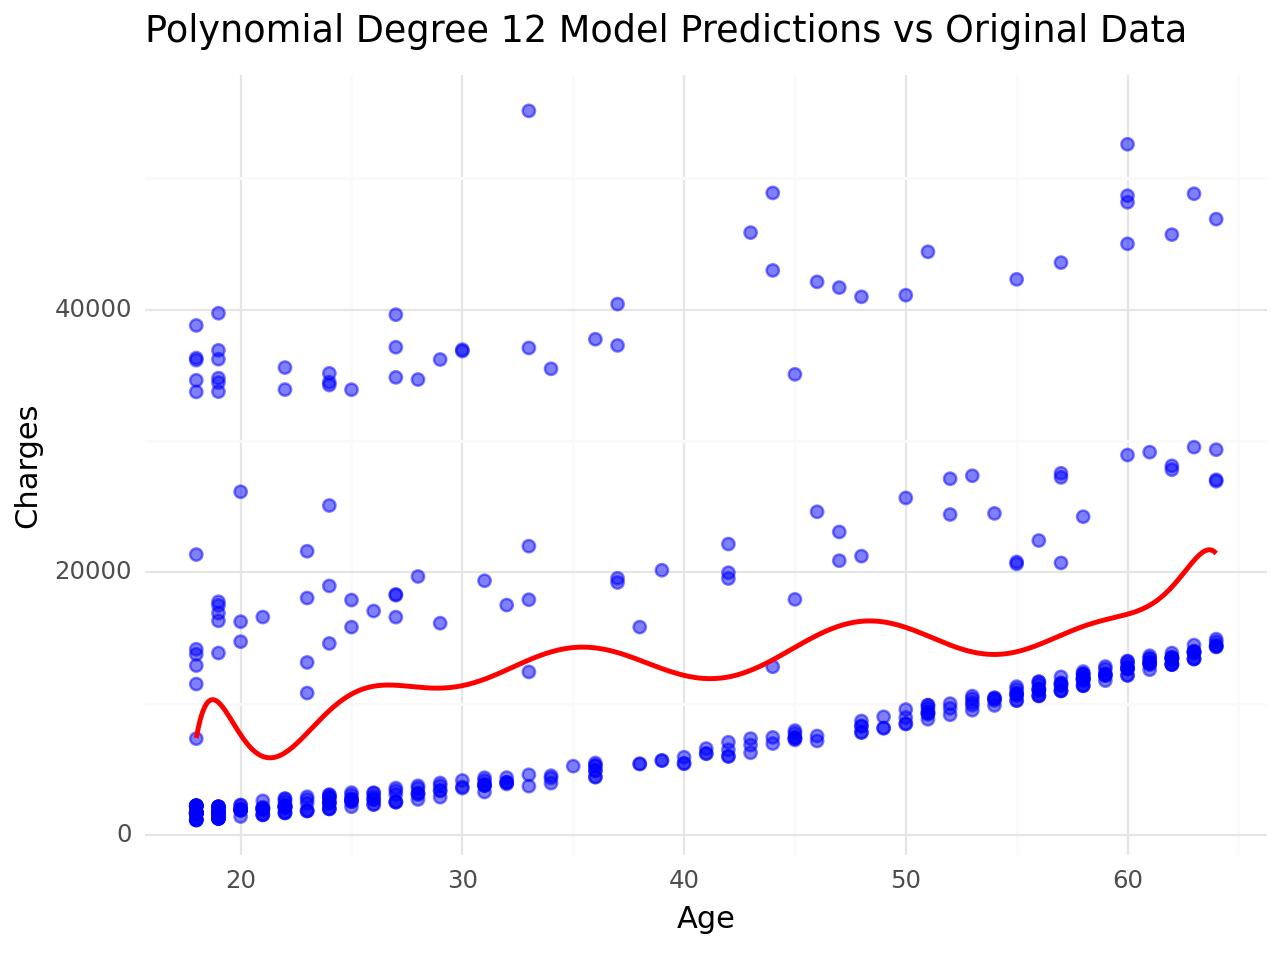

<Figure Size: (640 x 480)>

In [510]:

(
    ggplot(df, aes(x='age', y='charges')) +
    geom_point(color='blue', alpha=0.5, size=2) +
    geom_line(df_poly12_plot, aes(x='age', y='predicted_charges'), color='red', size=1) +
    labs(
        title='Polynomial Degree 12 Model Predictions vs Original Data',
        x='Age',
        y='Charges'
    ) +
    theme_minimal()
)

# Part Four: New data
Great news! We’ve managed to collect data about the insurance costs for a few more individuals. You can find the new dataset here: https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1

Consider the following possible models:

1. Only age as a predictor.

2. age and bmi as a predictor.

3. age, bmi, and smoker as predictors (no interaction terms)

4. age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

5. age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

For each model, fit the model on the original data.

Then, use the fitted model to predict on the new data.

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?

Make a plot showing the residuals of your final chosen model.

In [511]:
url = "https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1"
df_new = pd.read_csv(url)
df_new.head()

,age,sex,bmi,smoker,region,charges
0,23,male,34.400,no,southwest,1826.84300
1,56,male,40.300,no,southwest,10602.38500
2,18,male,34.100,no,southeast,1137.01100
3,63,female,23.085,no,northeast,14451.83515
4,63,male,28.310,no,northwest,13770.09790


In [512]:
# 1. Model with Age as a Predictor
pipeline1.fit(df[['age']], df[['charges']])
new_predictions_age = pipeline1.predict(df_new[['age']])
mse_new_age = mean_squared_error(df_new['charges'], new_predictions_age)
print(f"Model 1 (Age): MSE on New Data: {mse_new_age}")

Model 1 (Age): MSE on New Data: 136077136.50195494


In [513]:
# 2. Model with Age and BMI as Predictors
pipeline_age_bmi.fit(df[['age', 'bmi']], df[['charges']])
new_predictions_age_bmi = pipeline_age_bmi.predict(df_new[['age', 'bmi']])
mse_new_age_bmi = mean_squared_error(df_new['charges'], new_predictions_age_bmi)
print(f"Model 2 (Age & BMI): MSE on New Data: {mse_new_age_bmi}")

Model 2 (Age & BMI): MSE on New Data: 132636406.1108129


In [514]:
# 3. Model with Age, BMI, and Smoker as Predictors (No Interaction)

# Defining the ColumnTransformer for scaling and encoding
preprocessor_age_bmi_smoker = ColumnTransformer([
    ('scaler', StandardScaler(), ['age', 'bmi']),  # Standardizing age and bmi
    ('smoker_encoder', OneHotEncoder(drop='first'), ['smoker'])  # One-hot encoding smoker (binary encoding)
], remainder='drop')  # Dropping other columns not specified

# Creating the pipeline
pipeline_age_bmi_smoker = Pipeline([
    ('preprocessor', preprocessor_age_bmi_smoker),
    ('linear_regression', LinearRegression())
])

pipeline_age_bmi_smoker.fit(df[['age', 'bmi', 'smoker']], df[['charges']])
new_predictions_age_bmi_smoker = pipeline_age_bmi_smoker.predict(df_new[['age', 'bmi', 'smoker']])
mse_new_age_bmi_smoker = mean_squared_error(df_new['charges'], new_predictions_age_bmi_smoker)
print(f"Model 3 (Age, BMI, & Smoker): MSE on New Data: {mse_new_age_bmi_smoker}")

Model 3 (Age, BMI, & Smoker): MSE on New Data: 35377541.24141633


In [515]:
# 4. Model with Age, BMI, and with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)
# Encode 'smoker'
encoder = OneHotEncoder(drop='first', sparse_output=False)
smoker_encoded = encoder.fit_transform(df[['smoker']])
df_encoded = pd.DataFrame(smoker_encoded, columns=encoder.get_feature_names_out(['smoker']))
df = pd.concat([df.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)

# Standardize 'age' and 'bmi'
scaler = StandardScaler()
df[['age', 'bmi']] = scaler.fit_transform(df[['age', 'bmi']])

# Create interaction terms (age:smoker and bmi:smoker)
df['age:smoker'] = df['age'] * df['smoker_yes']
df['bmi:smoker'] = df['bmi'] * df['smoker_yes']

# Prepare features and target for model 4
X_model_4 = df[['age', 'bmi', 'age:smoker', 'bmi:smoker']]
y = df['charges']

# Fit the model
model_4 = LinearRegression()
model_4.fit(X_model_4, y)

# Apply transformations to new data
smoker_encoded_new = encoder.transform(df_new[['smoker']])
df_new_encoded = pd.DataFrame(smoker_encoded_new, columns=encoder.get_feature_names_out(['smoker']))
df_new = pd.concat([df_new.reset_index(drop=True), df_new_encoded.reset_index(drop=True)], axis=1)
df_new[['age', 'bmi']] = scaler.transform(df_new[['age', 'bmi']])
df_new['age:smoker'] = df_new['age'] * df_new['smoker_yes']
df_new['bmi:smoker'] = df_new['bmi'] * df_new['smoker_yes']

# Predict and calculate MSE for model 4
X_new_model_4 = df_new[['age', 'bmi', 'age:smoker', 'bmi:smoker']]
predictions_model_4 = model_4.predict(X_new_model_4)
mse_model_4 = mean_squared_error(df_new['charges'], predictions_model_4)
print(f"Model 4 (Age and BMI with interaction terms with Smoker): MSE on New Data: {mse_model_4}")

Model 4 (Age and BMI with interaction terms with Smoker): MSE on New Data: 128511296.37352593


In [516]:
# 5. Model with Age, BMI, and Smoker with Both Quantitative Variables Interacting with Smoker (~ (age + bmi)*smoker)
# Create additional terms for the full interaction model (age * smoker and bmi * smoker, along with individual terms)
df['age:bmi'] = df['age'] * df['bmi']
df['age:smoker'] = df['age'] * df['smoker_yes']
df['bmi:smoker'] = df['bmi'] * df['smoker_yes']
df['age:bmi:smoker'] = df['age'] * df['bmi'] * df['smoker_yes']

# Prepare features for model 5
X_model_5 = df[['age', 'bmi', 'smoker_yes', 'age:smoker', 'bmi:smoker', 'age:bmi', 'age:bmi:smoker']]

# Fit the model
model_5 = LinearRegression()
model_5.fit(X_model_5, y)

# Apply transformations to new data
df_new['age:bmi'] = df_new['age'] * df_new['bmi']
df_new['age:smoker'] = df_new['age'] * df_new['smoker_yes']
df_new['bmi:smoker'] = df_new['bmi'] * df_new['smoker_yes']
df_new['age:bmi:smoker'] = df_new['age'] * df_new['bmi'] * df_new['smoker_yes']

# Predict and calculate MSE for model 5
X_new_model_5 = df_new[['age', 'bmi', 'smoker_yes', 'age:smoker', 'bmi:smoker', 'age:bmi', 'age:bmi:smoker']]
predictions_model_5 = model_5.predict(X_new_model_5)
mse_model_5 = mean_squared_error(df_new['charges'], predictions_model_5)
print(f"Model 5 (Age, BMI, & Smoker with full interaction): MSE on New Data: {mse_model_5}")

Model 5 (Age, BMI, & Smoker with full interaction): MSE on New Data: 21649538.597077783


In [517]:
# Comparing MSE values for each model
mse_results = {
    'Model 1 (Age)': mse_new_age,
    'Model 2 (Age & BMI)': mse_new_age_bmi,
    'Model 3 (Age, BMI, & Smoker)': mse_new_age_bmi_smoker,
    'Model 4 (Age & BMI Interaction with Smoker)': mse_model_4,
    'Model 5 (Age, BMI, & Smoker with Interaction)': mse_model_5
}
best_model = min(mse_results, key=mse_results.get)
print(f"The best model based on MSE is: {best_model} with MSE: {mse_results[best_model]}")

The best model based on MSE is: Model 5 (Age, BMI, & Smoker with Interaction) with MSE: 21649538.597077783


In [518]:
df_new['predictions'] = predictions_model_5

# Calculate residuals for df_new
df_new['residuals'] = df_new['charges'] - df_new['predictions']  # Residuals = Actual - Predicted

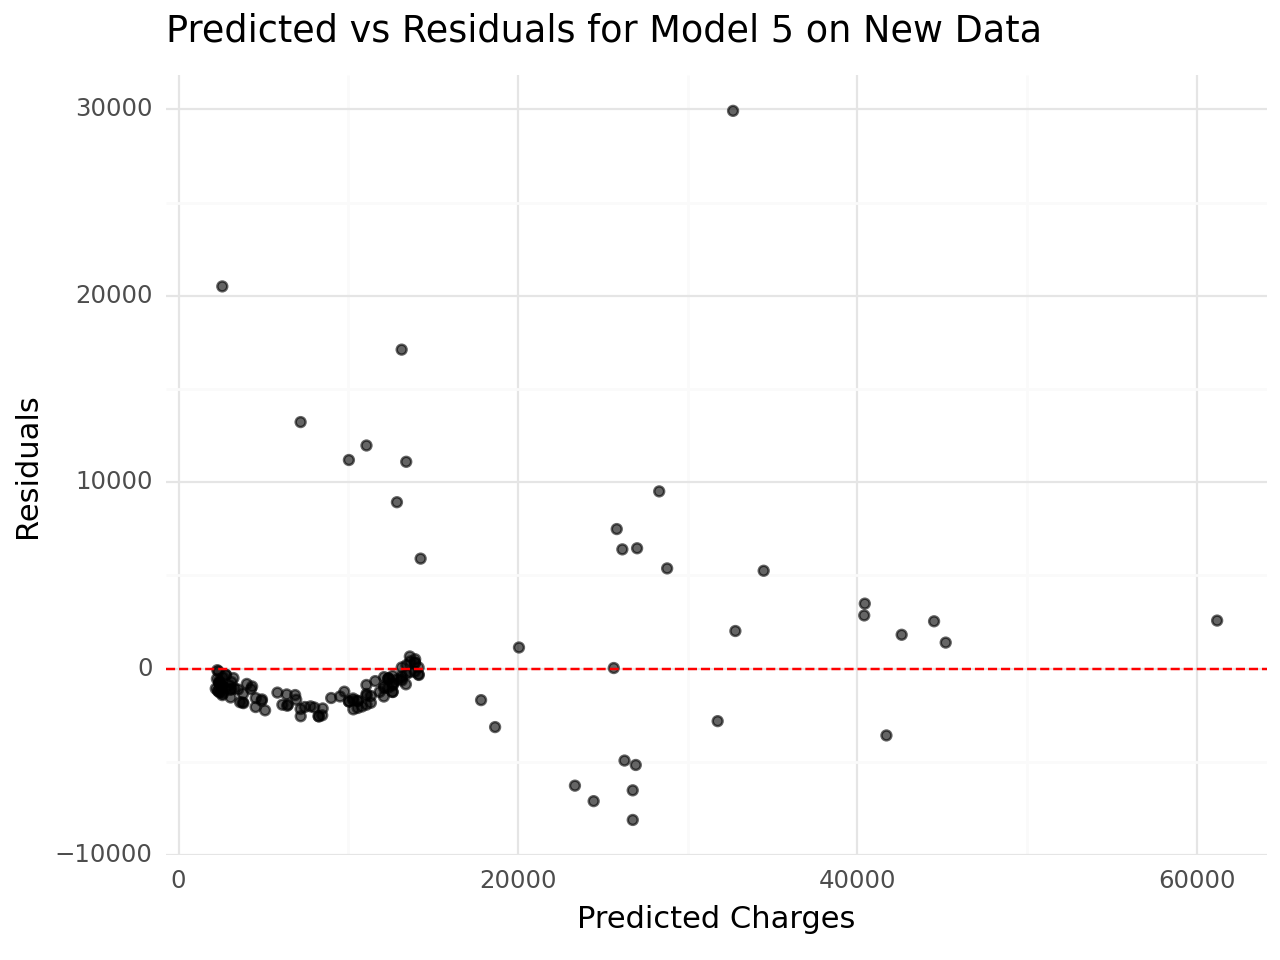

<Figure Size: (640 x 480)>

In [519]:
(
    ggplot(df_new, aes(x='predictions', y='residuals')) +
    geom_point(alpha=0.6) +
    geom_hline(yintercept=0, color='red', linetype='dashed') +
    labs(
        title="Predicted vs Residuals for Model 5 on New Data",
        x="Predicted Charges",
        y="Residuals"
    ) +
    theme_minimal()
)

# Part Five: Full Exploration

Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the new data after being fit on the original data.

Make a plot showing the residuals of your final chosen model.

In [520]:
X = df.drop(columns=['charges'])
y = df['charges']

preprocessor = ColumnTransformer(
    [
        ('age_bmi_scaler', StandardScaler(), ['age', 'bmi']),
        ('smoker_encoder', OneHotEncoder(drop='first', sparse_output=False), ['smoker'])
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial_features', PolynomialFeatures()),  # PolynomialFeatures transformer
    ('linear_regression', LinearRegression())
])

# Set up the hyperparameter grid for degrees of polynomial terms
param_grid = {'polynomial_features__degree': np.arange(1, 6)}  # Search from 1 to 5 degrees

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Best parameters and best score
print(f"Best Polynomial Degree: {grid_search.best_params_['polynomial_features__degree']}")
print(f"Best MSE Score (Cross-Validation): {-grid_search.best_score_}")

Best Polynomial Degree: 2
Best MSE Score (Cross-Validation): 19167919.20787617


In [521]:
# Use the best model to predict on new data
X_new = df_new.drop(columns=['charges'])
y_new = df_new['charges']
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_new)

# Calculate MSE on new data
from sklearn.metrics import mean_squared_error
r2_new = r2_score(y_new, predictions)
mse_new = mean_squared_error(y_new, predictions)
print(f"R2 on New Data with Best Model: {r2_new}")
print(f"MSE on New Data with Best Model: {mse_new}")

R2 on New Data with Best Model: 0.8611283665034086
MSE on New Data with Best Model: 21532023.68048747


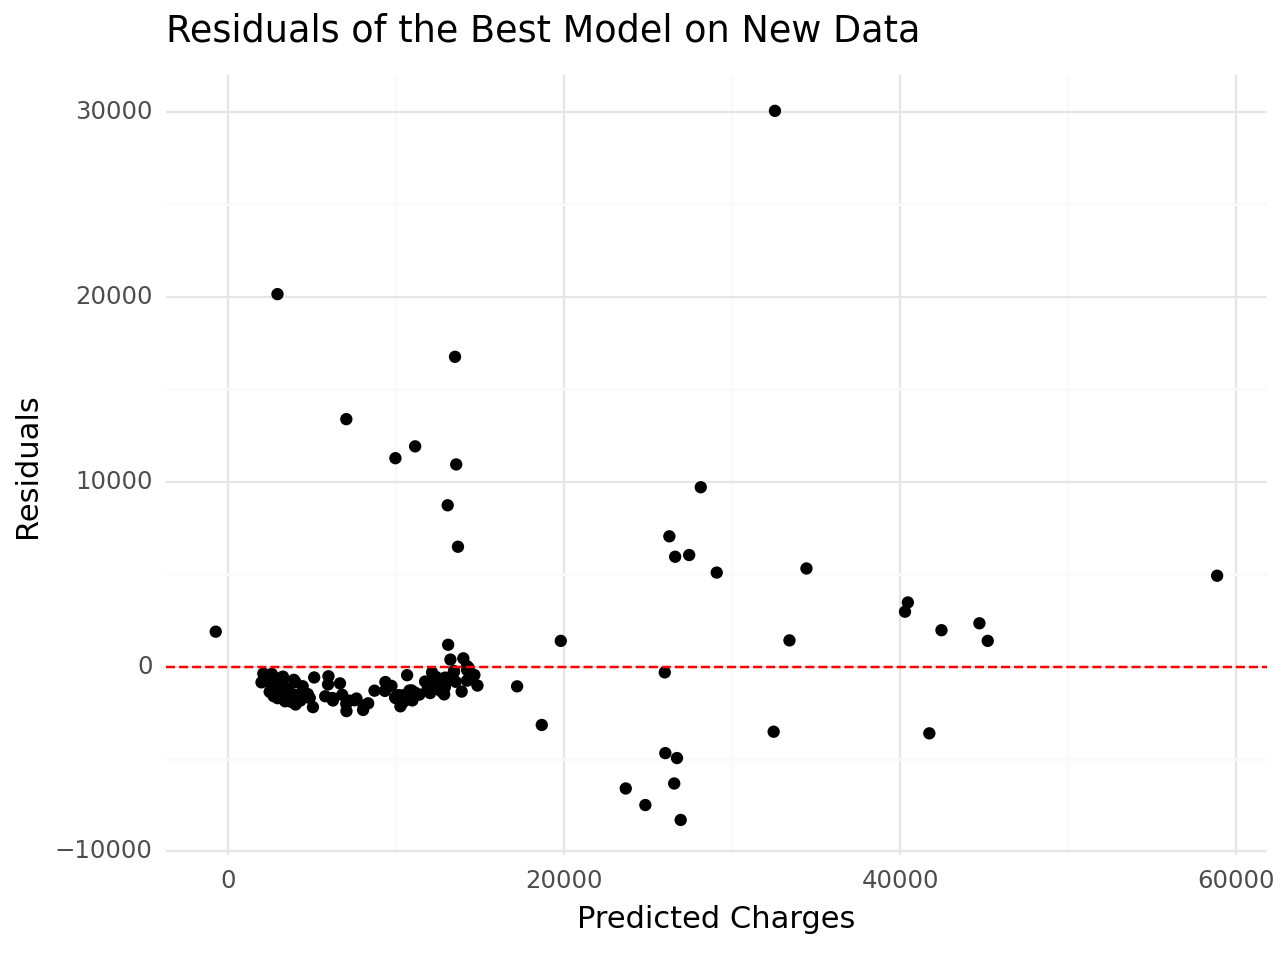

<Figure Size: (640 x 480)>

In [522]:
residuals = y_new - predictions
df_residuals = pd.DataFrame({'Predicted': predictions, 'Residuals': residuals})

(
    ggplot(df_residuals, aes(x='Predicted', y='Residuals')) +
    geom_point() +
    geom_hline(yintercept=0, color='red', linetype='dashed') +
    labs(title='Residuals of the Best Model on New Data', x='Predicted Charges', y='Residuals') +
    theme_minimal()
)

The best model used in this scenario incorporates a polynomial regression approach, including the variables age, bmi, and the binary indicator smoker. The model differs from model 5 in the previous part as it also introduces polynomial terms, which means it considers both individual terms and their interactions up to the specified degree (in this case, degree 2). This allows the model to account for nonlinear relationships and interaction effects between the predictors.

The final model equation looks something like this:
$$
\text{charges} = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{bmi} + \beta_3 \cdot \text{smoker} + \beta_4 \cdot \text{age}^2 + \beta_5 \cdot \text{bmi}^2 + \beta_6 \cdot \text{age} \cdot \text{bmi} + \beta_7 \cdot \text{age} \cdot \text{smoker} + \beta_8 \cdot \text{bmi} \cdot \text{smoker} + \ldots
$$

This complexity allows for capturing more nuanced effects and interactions in predicting insurance charges, as evidenced by the high \(R^2\) value of 0.861. However, as noted in the residual plot, some areas of the data, particularly for higher predicted charges, exhibit larger residuals, indicating areas where predictions are less accurate. This may suggest some limitations in the model's ability to generalize across the full range of values in the data, particularly with extreme or rare cases.